https://www.oreilly.com/learning/algorithmic-trading-in-less-than-100-lines-of-python-code
https://dannyvankooten.com/backtesting-12-month-sma-investing-strategy-pandas/


In [ ]:
https://dannyvankooten.com/backtesting-12-month-sma-investing-strategy-pandas/


In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pyfolio

In [2]:
import os
import pandas as pd

instrument = "SPY"
df = pd.read_csv(os.getcwd() + "/data/%s.csv" % instrument)   # load 20 years historical data

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d')    
df.set_index('timestamp', inplace=True)

df = df[['open', 'high', 'low', 'close', 'adjusted_close', 'volume']]

df.rename(columns={"open": "Open", "high": "High", "low": "Low", "adjusted_close": "Close", "volume": "Volume"}, inplace = True)

df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

df = df[:1250]

df.sort_index(inplace=True)
#print(df.info())
print(df.tail())

                Open      High      Low   Close    Volume
timestamp                                                
2020-02-07  332.8200  333.9941  331.600  332.20  64074382
2020-02-10  331.2300  334.7500  331.190  334.68  41779456
2020-02-11  336.1697  337.0200  334.684  335.26  54773045
2020-02-12  336.8300  337.6500  336.430  337.42  42844434
2020-02-13  335.8621  338.1200  335.560  337.06  51243455


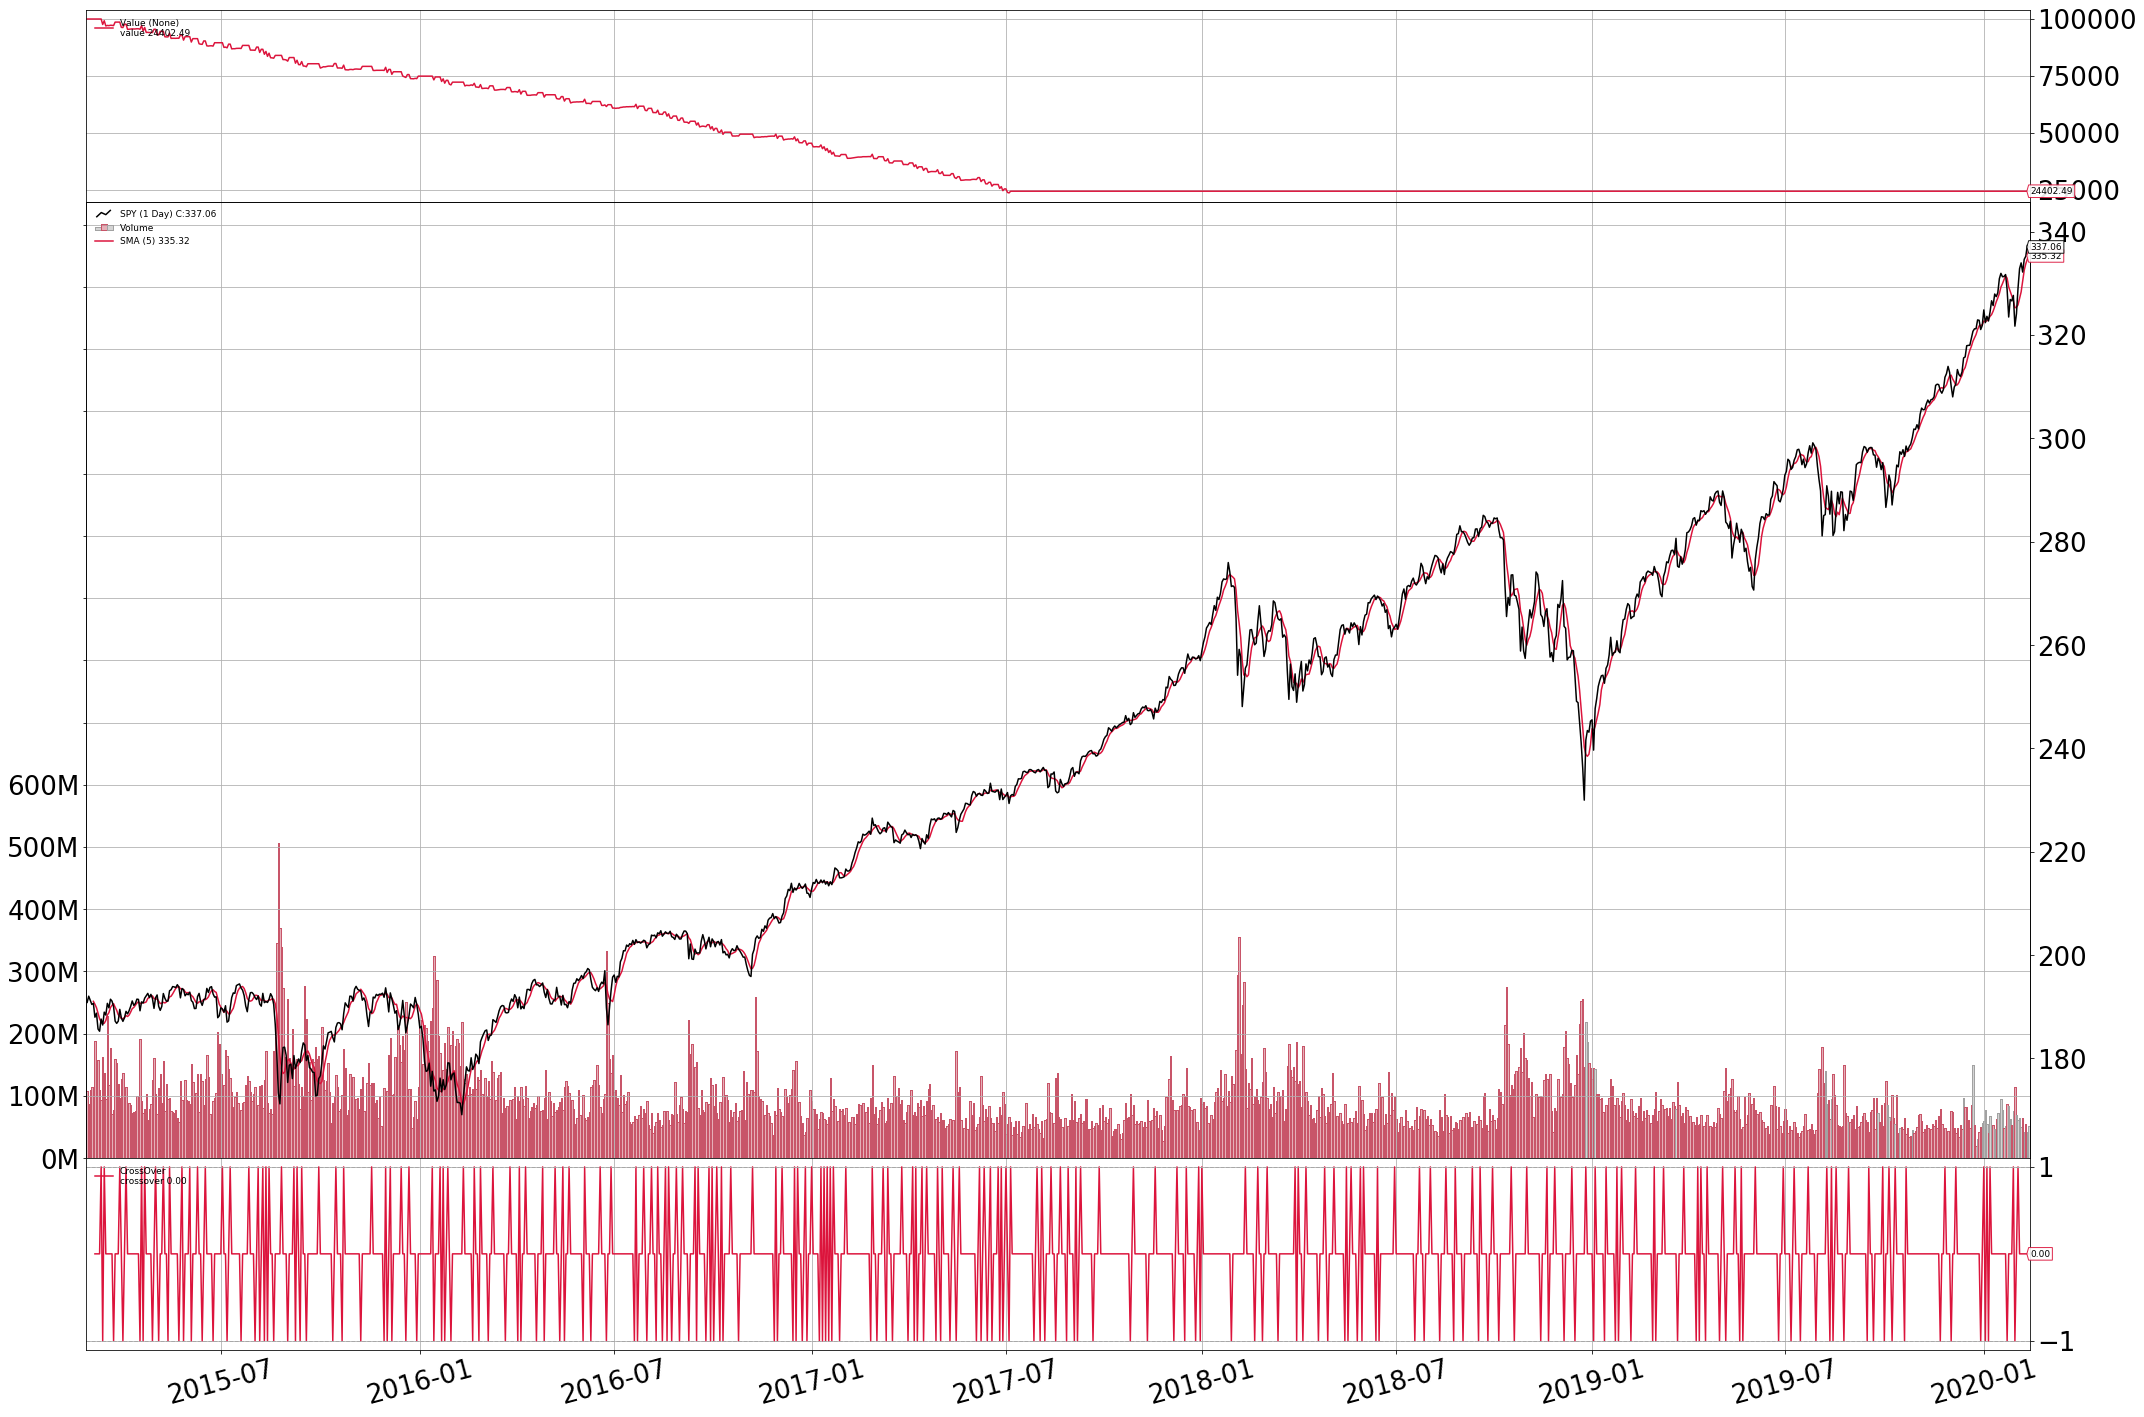

P/L: $-75597.51


In [5]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import math
import backtrader as bt
import backtrader.feeds as btfeeds


import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 30, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "26"

from collections import OrderedDict


class TrendFollower(bt.Strategy):
    '''This is a long-only strategy which operates on a moving average cross
    
    Entry rules:
        1. Go long  if:
            a. Current bar's close is greater than X-period moving average 
        2. Close position if:
            a. Current bar's close is lower than X-period moving average


    Order Execution Type:
      - Market
    Notes:
    '''
    params = (
        ('printlog', True),        
        ("period", 5)
        
        
    )

    def __init__(self):

        self.order = None
        # Add a ATR indicator for volatility measure
        #self.atr = bt.indicators.ATR(self.datas[0], period=20)

        # Bollinger Bands
        #self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)
        
        #self.cross_down = bt.indicators.CrossDown(self.data.close, self.boll.lines.top)
        #self.cross_up = bt.indicators.CrossUp(self.data.close, self.boll.lines.bot)
        
        sma = bt.indicators.MovAv.SMA(period=self.p.period)
        self.buysig = bt.indicators.CrossOver(self.data.close, sma)

        

    def next(self):
        # Simply log the closing price of the series from the reference
        #print('Close, %.2f' % self.data.close)

        
        if self.position.size:
            if self.buysig < 0:
                self.sell(size=100)

        elif self.buysig > 0:
            self.buy(size=100)
    

import numpy
datafeed = btfeeds.PandasData(dataname=df)

# Create an instance of cerebro
cerebro = bt.Cerebro(stdstats=True)
# Set our desired cash start
startcash = 100000
cerebro.broker.setcash(startcash)

# https://www.backtrader.com/docu/commission-schemes/commission-schemes/
# https://backtest-rookies.com/2017/09/26/backtrader-commission-schemes/
value_per_tick = 0.01  # value per tick see Trading Plan tables
decimal_digit_number = 2  # number of decimal digit after point
#cerebro.broker.setcommission(commission=2, margin=65,mult=value_per_tick / (10 ** -decimal_digit_number))
cerebro.broker.setcommission(commission=0.018)  # 1.8% of the operation value

# Analyzer
#cerebro.addanalyzer(bt.analyzers.DrawDown, _name='dd')
#cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='ta')

#cerebro.addanalyzer(bt.analyzers.SharpeRatio,  _name="mySharpe",  riskfreerate=0.01,     timeframe=bt.TimeFrame.Months)
#cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="myReturn")
#cerebro.addanalyzer(bt.analyzers.SQN, _name="mySqn")

#cerebro.addobserver(SLTPTracking)

# Add the strategy
cerebro.addstrategy(TrendFollower,printlog=False, period=5 )

# Add the data to Cerebro
cerebro.adddata(datafeed,name=instrument)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# Run over everything
#strategies = cerebro.run()

cerebro.addobserver(bt.observers.Value)
strategies = cerebro.run(stdstats=False)

cerebro.plot(style = 'line')
#first_strategy = strategies[0]

#Get final portfolio Value
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash

#Print out the final result
#print('Final Portfolio Value: ${}'.format(round(portvalue,2)))
print('P/L: ${}'.format(round(pnl,2)))
 


In [13]:
# Finally plot the end results
cerebro.plot(iplot=False, style='candlestick')

[[<Figure size 720x540 with 4 Axes>]]